✅ CSV 讀取成功：pokemon_newtype_zscore.csv (encoding=utf-8)

📌 類別分佈（原始資料）
Type_group
1    130
2    177
3    325
4    168
Name: count, dtype: int64

📌 類別分佈（Train）
Type_group
1    104
2    142
3    260
4    134
Name: count, dtype: int64

📌 類別分佈（Test）
Type_group
1    26
2    35
3    65
4    34
Name: count, dtype: int64

Classification Report (Train Set)
Accuracy: 0.4531
              precision    recall  f1-score   support

           1     0.3961    0.5865    0.4729       104
           2     0.4521    0.5986    0.5152       142
           3     0.6283    0.4615    0.5322       260
           4     0.2243    0.1791    0.1992       134

    accuracy                         0.4531       640
   macro avg     0.4252    0.4564    0.4298       640
weighted avg     0.4669    0.4531    0.4490       640


Classification Report (Test Set)
Accuracy: 0.4875
              precision    recall  f1-score   support

           1     0.4286    0.5769    0.4918        26
           2     0.4615    0.6857    0.5

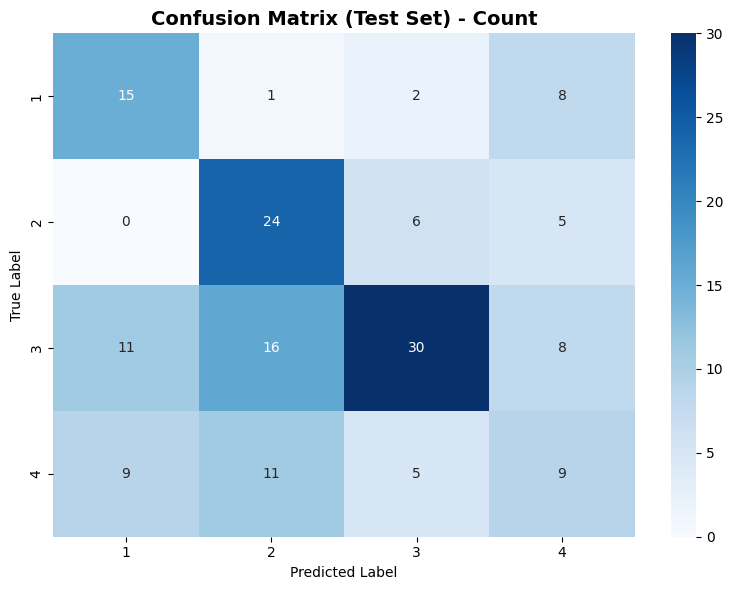

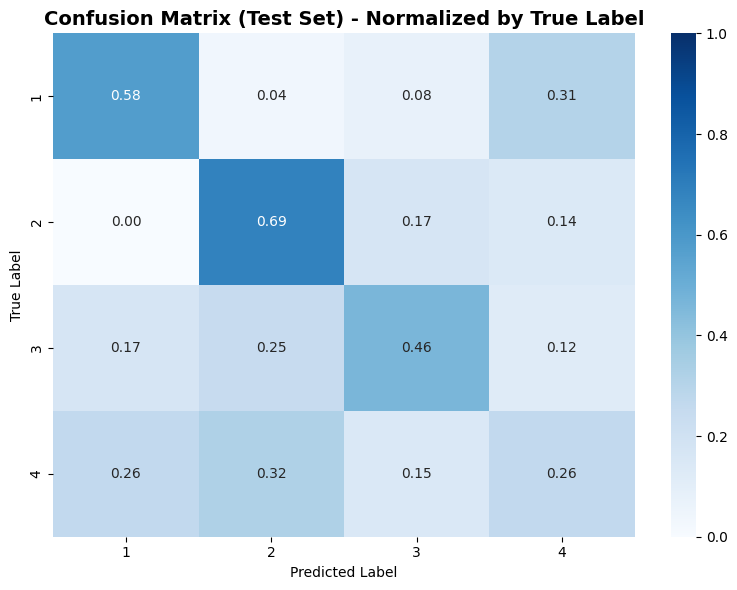

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

# ----------------------------------------------------
# 1. 資料載入
# ----------------------------------------------------
file_path = "pokemon_newtype_zscore.csv"

encodings = ["utf-8", "utf-8-sig", "cp950", "big5", "cp1252"]
df = None
used_encoding = None

for enc in encodings:
    try:
        df = pd.read_csv(file_path, encoding=enc)
        used_encoding = enc
        break
    except UnicodeDecodeError:
        continue

if df is None:
    raise RuntimeError("讀取 CSV 失敗：請確認檔案編碼或檔案是否損壞。")

print(f"✅ CSV 讀取成功：{file_path} (encoding={used_encoding})")

df.columns = df.columns.str.strip()

# ----------------------------------------------------
# 2. 指定特徵與標籤
# ----------------------------------------------------
feature_cols = ["HP", "Attack", "Defense", "Sp. Atk", "Sp. Def", "Speed"] #自變數(X)
target_col = "Type_group" #應變數(Y)

missing = [c for c in feature_cols + [target_col] if c not in df.columns]
if missing:
    print("❌ 你的 CSV 欄位如下：")
    print(df.columns.tolist())
    raise KeyError(f"缺少必要欄位：{missing}")

X = df[feature_cols].copy()
y = df[target_col].copy()

# 去掉缺值
data = pd.concat([X, y], axis=1).dropna()
X = data[feature_cols]
y = data[target_col]

print("\n📌 類別分佈（原始資料）")
print(y.value_counts().sort_index())

# ----------------------------------------------------
# 3. 切分 Train/Test（80/20，符合你說的 80/20）
# ----------------------------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,      # 20% test
    random_state=42,
    stratify=y
)

print("\n📌 類別分佈（Train）")
print(pd.Series(y_train).value_counts().sort_index())
print("\n📌 類別分佈（Test）")
print(pd.Series(y_test).value_counts().sort_index())

# ----------------------------------------------------
# 4. Softmax 回歸 + SMOTE（只對 Train 做）
#    注意：用 imblearn 的 Pipeline，避免資料洩漏
# ----------------------------------------------------
model = ImbPipeline(steps=[
    ("scaler", StandardScaler()),
    ("smote", SMOTE(random_state=42, k_neighbors=5)),
    ("softmax", LogisticRegression(
        solver="lbfgs",
        max_iter=5000,
        random_state=42

    ))
])

model.fit(X_train, y_train)

# ----------------------------------------------------
# 5. 產出 Train/Test 的報告（你要的「明確分開」）
# ----------------------------------------------------
def evaluate(split_name, X_split, y_split):
    y_pred = model.predict(X_split)
    acc = accuracy_score(y_split, y_pred)
    print("\n" + "="*60)
    print(f"Classification Report ({split_name})")
    print("="*60)
    print(f"Accuracy: {acc:.4f}")
    print(classification_report(y_split, y_pred, digits=4))
    return y_pred

y_pred_train = evaluate("Train Set", X_train, y_train)
y_pred_test  = evaluate("Test Set",  X_test,  y_test)

# ----------------------------------------------------
# 6. 混淆矩陣（Test Set）：Count + Normalized
# ----------------------------------------------------
classes = np.sort(y.unique())

cm = confusion_matrix(y_test, y_pred_test, labels=classes)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=classes, yticklabels=classes)
plt.title("Confusion Matrix (Test Set) - Count", fontsize=14, fontweight="bold")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.savefig("confusion_matrix_count.png", dpi=300)
print("\n✅ 已輸出：confusion_matrix_count.png")

# normalized by true label（每一列加總=1）
cm_norm = cm.astype(float) / cm.sum(axis=1, keepdims=True)
cm_norm = np.nan_to_num(cm_norm)  # 避免某列全0造成 NaN

plt.figure(figsize=(8, 6))
sns.heatmap(cm_norm, annot=True, fmt=".2f", cmap="Blues",
            xticklabels=classes, yticklabels=classes,
            vmin=0, vmax=1)
plt.title("Confusion Matrix (Test Set) - Normalized by True Label", fontsize=14, fontweight="bold")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.savefig("confusion_matrix_normalized.png", dpi=300)
print("✅ 已輸出：confusion_matrix_normalized.png")



In [2]:
# ----------------------------------------------------
# 7. 進階評估：5-Fold Cross-Validation (詳細每一折完整報告 + 最終統計)
# ----------------------------------------------------
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone
from sklearn.metrics import accuracy_score # 確保有引入這行
import numpy as np

print("\n" + "="*80)
print("Running 5-Fold Cross-Validation (Detailed Classification Reports)")
print("="*80)

# 使用 StratifiedKFold 確保每一折的類別比例一致
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 確保資料格式為 numpy array 以便進行索引切分
X_train_np = X_train.values if hasattr(X_train, 'values') else X_train
y_train_np = y_train.values if hasattr(y_train, 'values') else y_train

# 【新增 1】建立一個空清單，用來存每一折的驗證準確率
val_accuracies = []

for fold_idx, (train_idx, val_idx) in enumerate(kf.split(X_train_np, y_train_np), 1):
    # 1. 切分訓練資料與驗證資料
    X_fold_train, X_fold_val = X_train_np[train_idx], X_train_np[val_idx]
    y_fold_train, y_fold_val = y_train_np[train_idx], y_train_np[val_idx]

    # 2. 訓練模型 (複製一個新的 best_model 來跑，避免影響原模型)
    model_clone = clone(model)
    model_clone.fit(X_fold_train, y_fold_train)

    # 3. 產生預測結果
    y_fold_train_pred = model_clone.predict(X_fold_train)
    y_fold_val_pred   = model_clone.predict(X_fold_val)

    # 【新增 2】計算該折的準確率並存起來
    acc = accuracy_score(y_fold_val, y_fold_val_pred)
    val_accuracies.append(acc)

    # 4. 印出該折的詳細報告
    print(f"\n{'#'*30} FOLD {fold_idx} (Acc: {acc:.4f}) {'#'*30}")

    print(f"\n--- Fold {fold_idx} Train Set Report ---")
    print(classification_report(y_fold_train, y_fold_train_pred, digits=4, zero_division=0))

    print(f"\n--- Fold {fold_idx} Validation Set Report ---")
    print(classification_report(y_fold_val, y_fold_val_pred, digits=4, zero_division=0))

# ----------------------------------------------------
# 【新增 3】迴圈結束後，計算平均值與標準差
# ----------------------------------------------------
mean_acc = np.mean(val_accuracies)
std_acc = np.std(val_accuracies)

print("\n" + "="*80)
print("5-Fold Cross-Validation Final Results")
print("="*80)
print(f"個別準確率 (Individual Accuracies): {val_accuracies}")
print(f"平均準確率 (Mean Accuracy):       {mean_acc:.4f}")
print(f"標準差 (Standard Deviation):      {std_acc:.4f}")
print("="*80)


Running 5-Fold Cross-Validation (Detailed Classification Reports)

############################## FOLD 1 (Acc: 0.4453) ##############################

--- Fold 1 Train Set Report ---
              precision    recall  f1-score   support

           1     0.3953    0.6071    0.4789        84
           2     0.4207    0.6106    0.4982       113
           3     0.6222    0.4038    0.4898       208
           4     0.2262    0.1776    0.1990       107

    accuracy                         0.4355       512
   macro avg     0.4161    0.4498    0.4165       512
weighted avg     0.4578    0.4355    0.4291       512


--- Fold 1 Validation Set Report ---
              precision    recall  f1-score   support

           1     0.3714    0.6500    0.4727        20
           2     0.4200    0.7241    0.5316        29
           3     0.8000    0.3846    0.5195        52
           4     0.1667    0.1111    0.1333        27

    accuracy                         0.4453       128
   macro avg     


Calculating Precision-Recall & mAP
Mean Average Precision (mAP, micro-averaged): 0.5029

✅ 已輸出：multiclass_pr_curve.png


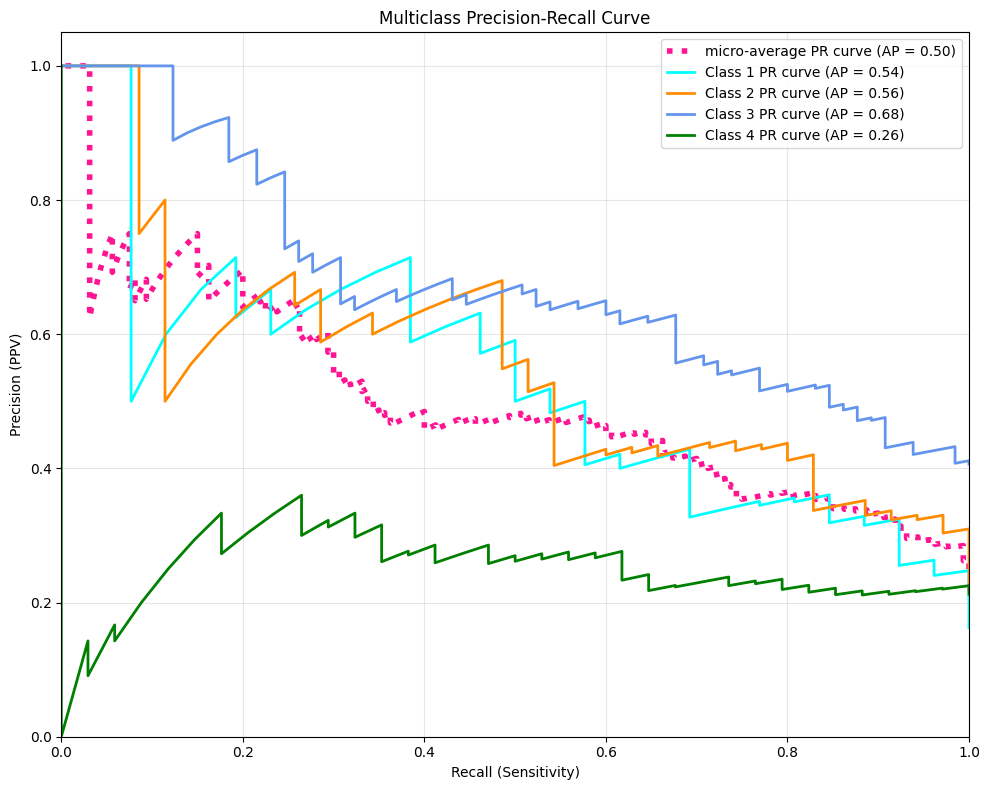

In [3]:
# ----------------------------------------------------
# 7. 進階評估：Precision-Recall Curve & mAP (取代 ROC)
# ----------------------------------------------------
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.preprocessing import label_binarize

# 注意：此處已刪除 5-Fold Cross-Validation 部分

# --- Multiclass Precision-Recall & mAP ---
print("\n" + "="*60)
print("Calculating Precision-Recall & mAP")
print("="*60)

# 1. 取得測試集的預測機率 (Probability)
# 如果您前面是用 GridSearch，請確保這裡使用的是 best_model
y_score = model.predict_proba(X_test)

# 2. 將標籤二值化 (One-vs-Rest 需將 Label 轉為 0/1 矩陣)
classes = sorted(y.unique())
y_test_bin = label_binarize(y_test, classes=classes)
n_classes = y_test_bin.shape[1]

# 3. 計算每個類別的 Precision, Recall 與 Average Precision (AP)
precision = dict()
recall = dict()
average_precision = dict()

for i in range(n_classes):
    # 計算該類別 vs 其他所有類別
    precision[i], recall[i], _ = precision_recall_curve(y_test_bin[:, i], y_score[:, i])
    average_precision[i] = average_precision_score(y_test_bin[:, i], y_score[:, i])

# 4. 計算 Micro-average PR curve & AP (整體平均表現)
# Micro-average 會將所有類別的預測合在一起看，適合看整體模型能力
precision["micro"], recall["micro"], _ = precision_recall_curve(y_test_bin.ravel(), y_score.ravel())
average_precision["micro"] = average_precision_score(y_test_bin, y_score, average="micro")

print(f"Mean Average Precision (mAP, micro-averaged): {average_precision['micro']:.4f}")

# 5. 繪圖
plt.figure(figsize=(10, 8))
lw = 2

# 畫 Micro-average 線 (粉紅色虛線)
plt.plot(recall["micro"], precision["micro"],
         label=f'micro-average PR curve (AP = {average_precision["micro"]:0.2f})',
         color='deeppink', linestyle=':', linewidth=4)

# 畫每個類別的線
colors = ['aqua', 'darkorange', 'cornflowerblue', 'green', 'red', 'purple']
for i, color in zip(range(n_classes), colors):
    # 避免顏色不夠用的保護機制
    c = color if i < len(colors) else 'gray'
    plt.plot(recall[i], precision[i], color=c, lw=lw,
             label=f'Class {classes[i]} PR curve (AP = {average_precision[i]:0.2f})')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall (Sensitivity)')
plt.ylabel('Precision (PPV)')
plt.title('Multiclass Precision-Recall Curve')
plt.legend(loc="best") # 自動找最佳位置放圖例
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig("multiclass_pr_curve.png", dpi=300)
print("\n✅ 已輸出：multiclass_pr_curve.png")


Generating Learning Curve...
✅ 已輸出：learning_curve.png


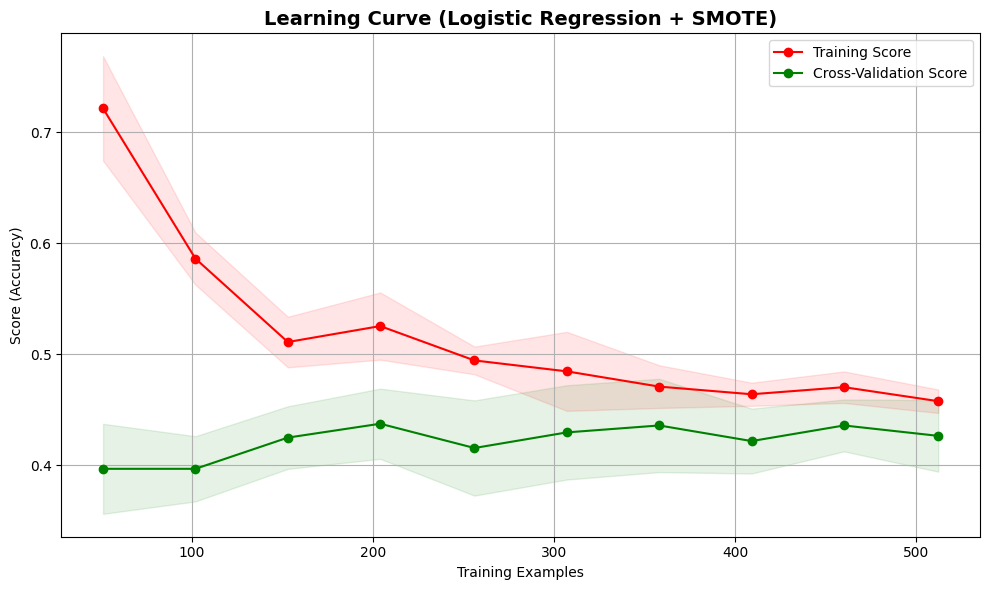

In [4]:
# ----------------------------------------------------
# 8. 進階評估：Learning Curve (學習曲線)
# ----------------------------------------------------
from sklearn.model_selection import learning_curve

print("\n" + "="*60)
print("Generating Learning Curve...")
print("="*60)

# 定義訓練樣本數的區間 (從 10% 到 100% 的訓練資料)
train_sizes_seq = np.linspace(0.1, 1.0, 10)

# 計算 Learning Curve
# 注意：這裡傳入整個 Pipeline (model)，確保 SMOTE 流程正確
train_sizes, train_scores, test_scores = learning_curve(
    model,
    X_train,
    y_train,
    cv=5,                # 5-fold cross-validation
    scoring='accuracy',  # 評估指標
    train_sizes=train_sizes_seq,
    n_jobs=-1            # 使用所有 CPU 核心加速
)

# 計算平均值與標準差
train_mean = np.mean(train_scores, axis=1)
train_std  = np.std(train_scores, axis=1)
test_mean  = np.mean(test_scores, axis=1)
test_std   = np.std(test_scores, axis=1)

# 繪圖
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, 'o-', color="r", label="Training Score")
plt.plot(train_sizes, test_mean, 'o-', color="g", label="Cross-Validation Score")

# 畫出標準差的陰影區域 (代表模型穩定度)
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std,
                 alpha=0.1, color="r")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std,
                 alpha=0.1, color="g")

plt.title("Learning Curve (Logistic Regression + SMOTE)", fontsize=14, fontweight='bold')
plt.xlabel("Training Examples")
plt.ylabel("Score (Accuracy)")
plt.legend(loc="best")
plt.grid(True)
plt.tight_layout()
plt.savefig("learning_curve.png", dpi=300)
print("✅ 已輸出：learning_curve.png")